In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('bodyPerformanceI.csv')

In [3]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,24.0,F,152.4,42.5,23.4,57.0,112.0,27.4,14.2,50.0,184.0,C
1,27.0,F,162.1,70.9,35.7,97.0,148.0,30.6,11.0,42.0,157.0,D
2,23.0,M,173.7,68.3,13.6,76.0,137.0,47.7,16.5,48.0,208.0,C
3,31.0,M,168.2,70.5,15.5,82.0,145.0,39.6,19.9,66.0,264.0,C
4,25.0,M,175.1,64.8,6.9,65.0,118.0,42.0,19.8,49.0,252.0,B


In [4]:
# Всего 7015 человек
df.shape

(7015, 12)

In [5]:
df.mean(numeric_only=True)

age                         36.801283
height_cm                  168.751732
weight_kg                   67.046887
body fat_%                  22.642606
diastolic                   78.648952
systolic                   130.364490
gripForce                   37.289624
sit and bend forward_cm     15.790925
sit-ups counts              40.614597
broad jump_cm              191.824391
dtype: float64

### Describe summary
1. Средний возраст людей 36 лет.
2. Средний рост составляет 168.75см.
3. Средний показатель body fat_% 22.64%.

### Gender

In [6]:
# Распределение участников по гендеру в датасете
df.gender.value_counts()

M    4552
F    2463
Name: gender, dtype: int64

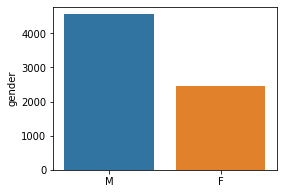

In [7]:
plt.figure(figsize=(4,3))
sns.barplot(data=df, x=df.gender.value_counts().index, y=df.gender.value_counts());

In [8]:
# Процентное распределение полов в датасете
df['gender'].value_counts(normalize=True)*100

M    64.889522
F    35.110478
Name: gender, dtype: float64

### Summary gender
#### Всего участников: 7015 
Мужчины:  4552 <br> 
Женщины:  2463 <br>
#### % распределение:<br>
Мужчины: 64.89% <br>
Женщины: 35.11%

### Class
Распределение участников по классам

In [9]:
# Кол-во участников распределенный по классам
df["class"].value_counts()

B    3222
C    2565
A     617
D     611
Name: class, dtype: int64

In [10]:
# Процентное распределение участнкиов по классам
df["class"].value_counts(normalize=True)*100

B    45.930150
C    36.564505
A     8.795438
D     8.709907
Name: class, dtype: float64

In [11]:
# Распределение участников по полам в классах
pd.crosstab(df["class"], df.gender)

gender,F,M
class,,
A,268,349
B,1142,2080
C,853,1712
D,200,411


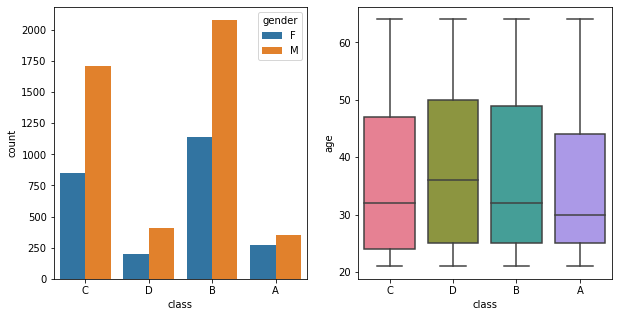

In [12]:
#Клаасы и пол
#Классы и возраст
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.countplot(x="class", hue="gender", data=df, ax=ax)
ax = plt.subplot(1,2,2)
sns.boxplot(x="class", y="age", palette='husl', data=df, ax=ax);

1. В классах <b>B</b> и <b>C</b> мужчин намного больше чем женщин.
2. Людей в классах <b>D</b> и <b>A</b> намного меньше чем в других.
3. Средний возраст участников в классе <b>А</b> наименьшее, чем в остальных, а в классе <b>D</b> выше всех.

In [13]:
# Средний возраст участников в классах
df.groupby("class")["age"].mean()

class
A    35.207455
B    37.108628
C    36.463158
D    38.209493
Name: age, dtype: float64

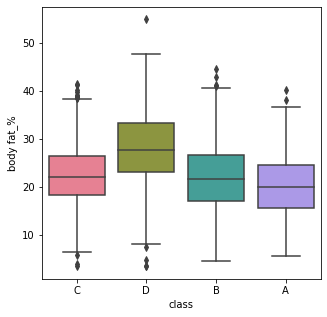

In [14]:
#Классы и процент жирности %
plt.figure(figsize=(11,5))
ax = plt.subplot(1,2,1)
sns.boxplot(x="class", y="body fat_%", palette='husl', data=df, ax=ax);

In [15]:
df.groupby("class")["body fat_%"].mean()

class
A    20.337344
B    22.073717
C    22.630745
D    28.020234
Name: body fat_%, dtype: float64

В среднем люди в классе <b>А</b> имеют более низкий уровень жира в организме(body fat_%)

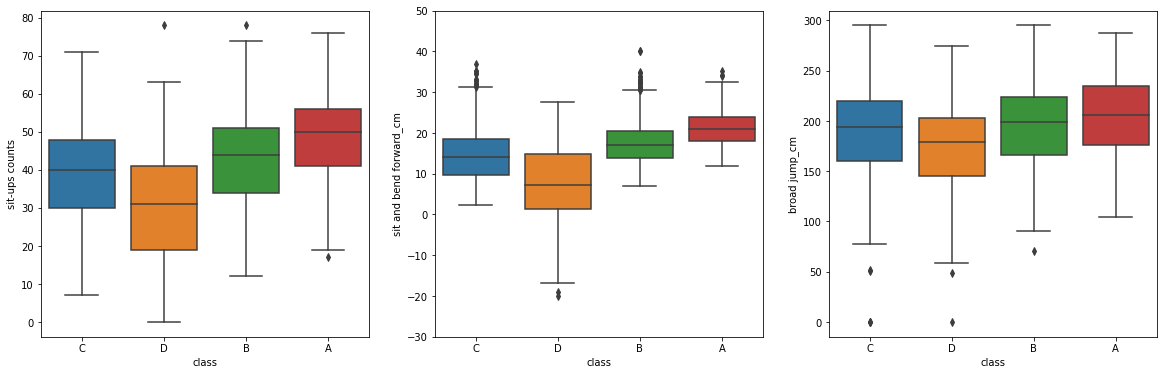

In [16]:
#class и sit ups, bendforward, broad jump
plt.figure(figsize=(20,6))
ax = plt.subplot(1,3,1)
sns.boxplot(x="class", y="sit-ups counts", data=df, ax=ax)
ax = plt.subplot(1,3,2)
sns.boxplot(x="class", y="sit and bend forward_cm", data=df, ax=ax)
ax.set(ylim=(-30,50))
ax = plt.subplot(1,3,3)
sns.boxplot(x="class", y="broad jump_cm", data=df, ax=ax);

In [17]:
df.groupby("class")[["sit-ups counts", "sit and bend forward_cm", "broad jump_cm"]].mean()

,sit-ups counts,sit and bend forward_cm,broad jump_cm
class,,,
A,48.311183,21.331605,204.387358
B,42.610615,17.469091,195.230012
C,38.835867,14.358515,188.888109
D,29.783961,7.359640,173.505728


<b>Summary</b>: В среднем, люди в классе <b>А</b>, как правило больше приседают, делают наклонов в перед и делают пресс (работают). То есть, у людей в классе <b>А</b> лучшие показатели, чем в у людей, других классах.

### Summary classes
#### Кол-во участников по группам: 
B:    3222 <br>
C:    2565 <br>
A:     617 <br>
D:     611 
#### Процентное распределение участников по группам
B: 45% <br>
C: 37% <br>
A: 8.8% <br>
D: 8.7% 



### Age

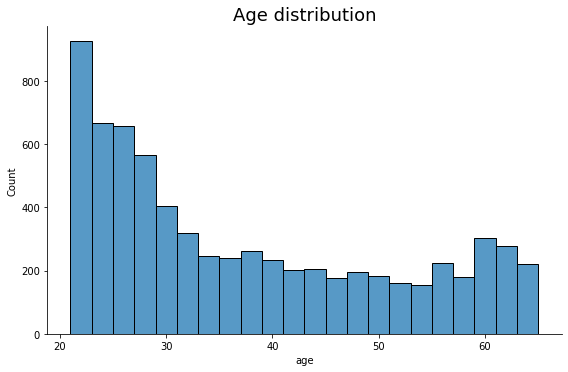

In [18]:
# Распределение возрастов людей
sns.displot(x='age', data=df, binwidth=2, height=5, aspect=1.6);
plt.title('Age distribution', fontsize=18);

<b>Age</b> : Возраст людей в датасете лежит в интервале от 20 до 64

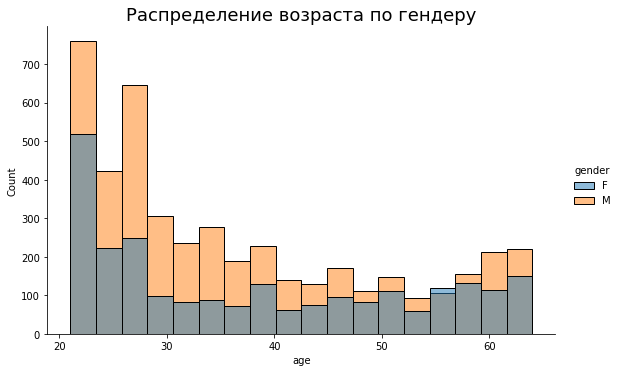

In [19]:
# Распределение возрастов по гендеру
sns.displot(df, x="age", hue="gender", height=5, aspect=1.6)
plt.title('Распределение возраста по гендеру', fontsize=18);

<b>Summary</b>: В интервале <b> 20, 40 </b> лет, молодые мужчины значительно больше чем женщин, но увиличением возраста - эта разница не существенно.

In [20]:
# Percentange distribution participants in certain age, form 20 to 30
age_list = []
def age_distribution(df):
    for age in df['age']:
        if 20 < age < 30:
            age_list.append(age)

    return (len(age_list) / df.age.count())*100

print(f'Percentage of young participants: {round(age_distribution(df),2)}%')

Percentage of young participants: 43.16%


In [21]:
# Max and min age of participants in data
print(f'Max: {df.age.max()}', f'\nMin: {df.age.min()}')

Max: 64.0 
Min: 21.0



<b>Summary</b>: 43% людей в датасате - это молодые люди от 20 до 30 лет. При этом минимальный возраст 21 лет, самому старшему 64. Также, среди мужчин и женщин только в среднем возрасте имеется небольшая разница, а остальные совпадают.


### Height & Weight

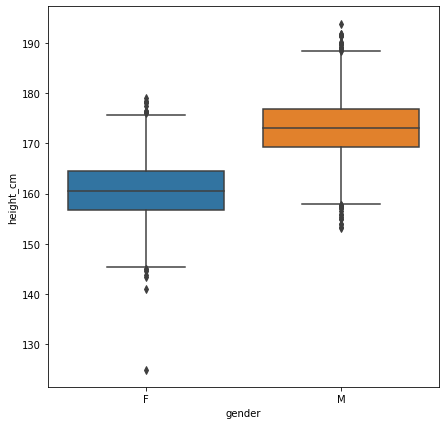

In [22]:
# Распределение роста полов
plt.figure(figsize=(7,7))
sns.boxplot(x='gender', y='height_cm', data=df);

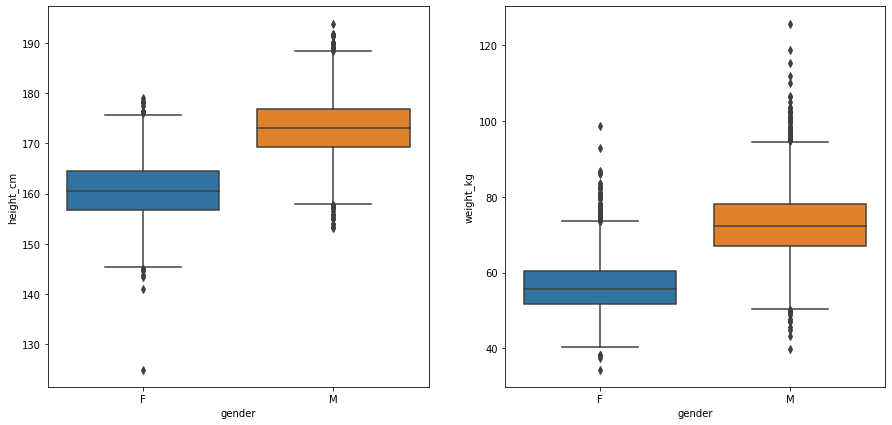

In [23]:
#Пол и height / весь
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
sns.boxplot(x="gender", y="height_cm", data=df, ax=ax)
ax = plt.subplot(1,2,2)
sns.boxplot(x="gender", y="weight_kg", data=df, ax=ax);

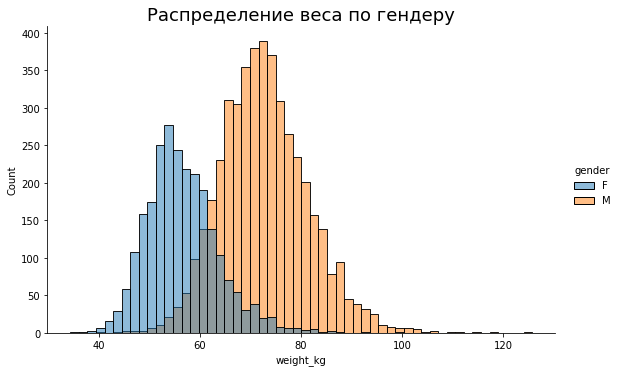

In [24]:
# Age distribution by gender
sns.displot(df, x="weight_kg", hue="gender", height=5, aspect=1.6)
plt.title('Распределение веса по гендеру', fontsize=18);

In [25]:
df.groupby(["gender"])[['height_cm','weight_kg']].mean()

,height_cm,weight_kg
gender,,
F,160.632887,56.505311
M,173.144684,72.750732


<b>Summary</b>: Данный график показывает, мужчины более <b>тяжелее</b> и <b>выше</b> женщин. Их среднее значения указны вверхней таблице

In [26]:
# Данная функция удаляет выбросы
def remove_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

w_outliers_data = remove_outliers(df, 'height_cm')

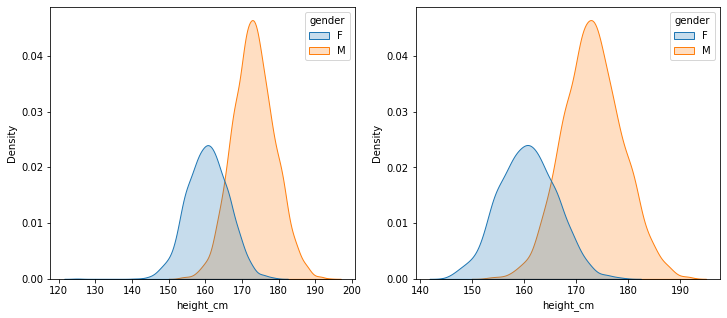

In [27]:
# Сопоставление ростов полов, при удалении резких выбросов
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
sns.kdeplot(data=df, x="height_cm", hue="gender", fill=True, ax=axs[0])
sns.kdeplot(data=w_outliers_data, x="height_cm", hue="gender", fill=True, ax=axs[1]);

In [28]:
men = df[df['gender']=='M']
women = df[df['gender']=='F']

def max_and_min_height(df):
    min_ = df.height_cm.min()
    max_ = df.height_cm.max()
    
    def mean_height():
        mean_ = df.height_cm.mean()
        return mean_
    return max_, mean_height(), min_


height = ['Max height', 'Mean height', 'Min height']
_women = max_and_min_height(women)
_men = max_and_min_height(men)
men_and_women_heights = pd.DataFrame({'Height':height, 'Men': _men, 'Women': _women})
men_and_women_heights

,Height,Men,Women
0,Max height,193.800000,179.000000
1,Mean height,173.144684,160.632887
2,Min height,153.100000,125.000000


### Summary height
1. В колонке рост, у женщин есть небольшие выбросы, но при их удалении на средний рост не сильно повлиял.
2. Средний рост мужчин на <b>13cм</b> больше, чем у женщин.
3. В показателях минимального и максимально роста среди мужчин и женщин есть существенная разница.

(0.0, 150.0)

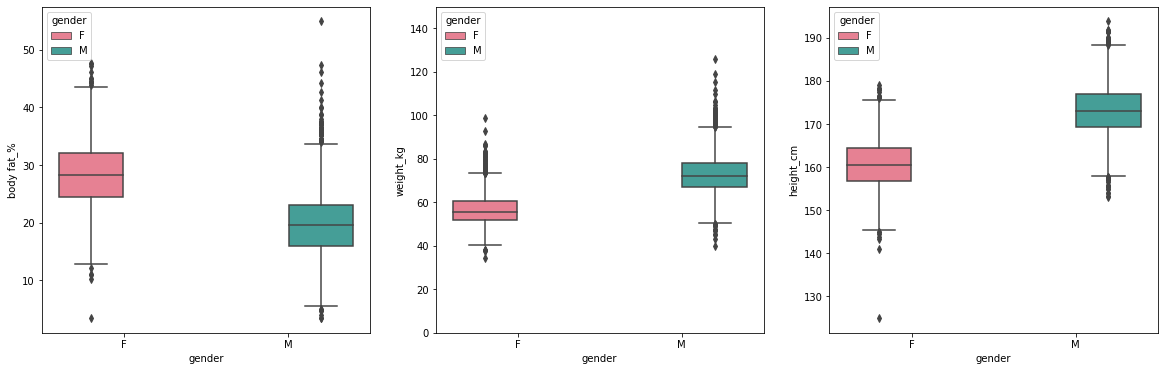

In [29]:
# Бокс распределение по трем параметрам: рост, весь, процент жира
fig, axes = plt.subplots(1,3, figsize=(20,6))
var = ['body fat_%', 'weight_kg', 'height_cm']
for var, axis in zip(var, axes):
    sns.boxplot(x='gender', y=var, data=df, palette='husl',ax=axis, hue='gender')
axes[1].set_ylim(0, 150)

In [30]:
df.groupby(['gender'])[['body fat_%']].mean()

,body fat_%
gender,
F,28.204907
M,19.632951


<b>Summary</b>: Средний показатель процента жира, в организме у женщин (28%) выше, чем у мужчин (19.6%). Если ввести в график еще и весь, то получается, что у мужчин средний весь больше чем у женщин, но при этом процент жира меньше, и наоборот.

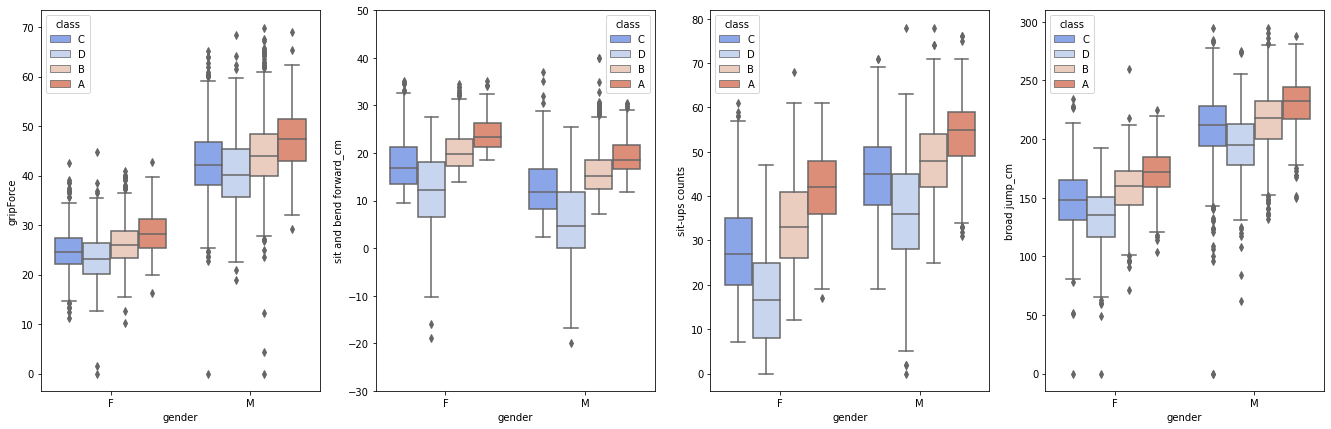

In [31]:
# Упражнения/силовые показатели
fig, axes = plt.subplots(1,4, figsize=(23,7))
var = ['gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm']
for var, axis in zip(var, axes):
    sns.boxplot(x='gender', y=var, data=df, palette='coolwarm',ax=axis, hue='class')
axes[1].set_ylim(-30, 50);

<b>Summary</b>: <b>Sit and band</b> показывает, что женщины более гибкие, чем мужчины, но мужчины более сильные gripForce. Показатели, у людей в группе <b>А</b> самые лучшие из всех классов, а также ммужчины из класса А показывают лучшие результаты, чем остальные мужчины из других групп.

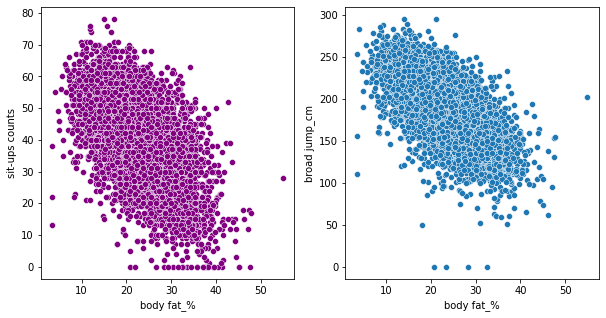

In [32]:
#Процент жирности и sit ups
#Процент жирности и прыжок
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="body fat_%", y="sit-ups counts", data=df, ax=ax, color='purple')
ax = plt.subplot(1,2,2)
sns.scatterplot(x="body fat_%", y="broad jump_cm", data=df, ax=ax);

<b>Summary:</b> Люди с более низким процентом жира в организме, как правило, могут делать больше работать на пресс (sit up coubnts). Более того, люди с более низким процентом жира в организме, как правило, могут прыгать в длину на большее расстояние.

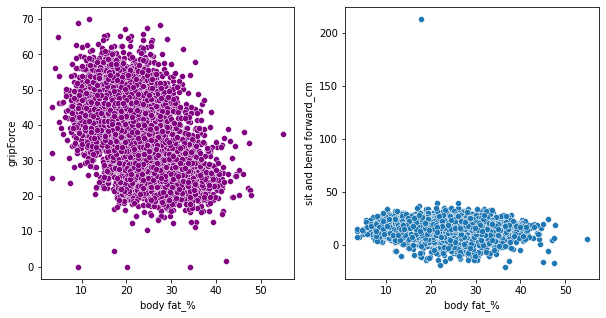

In [33]:
#Body fat and gripfore
#Body fat and bend forward
plt.figure(figsize=(10,5))
ax = plt.subplot(1,2,1)
sns.scatterplot(x="body fat_%", y="gripForce", data=df, ax=ax, color='purple')
ax = plt.subplot(1,2,2)
sns.scatterplot(x="body fat_%", y="sit and bend forward_cm", data=df, ax=ax);

<b>Summary:</b> Люди с более низким процентом жира в организме имеют более высокую силу захвата (gripForce). Также, нет никакой корреляции между процентным содержанием жира в организме и способностью наклоняться вперед.

### Correlation

<AxesSubplot:>

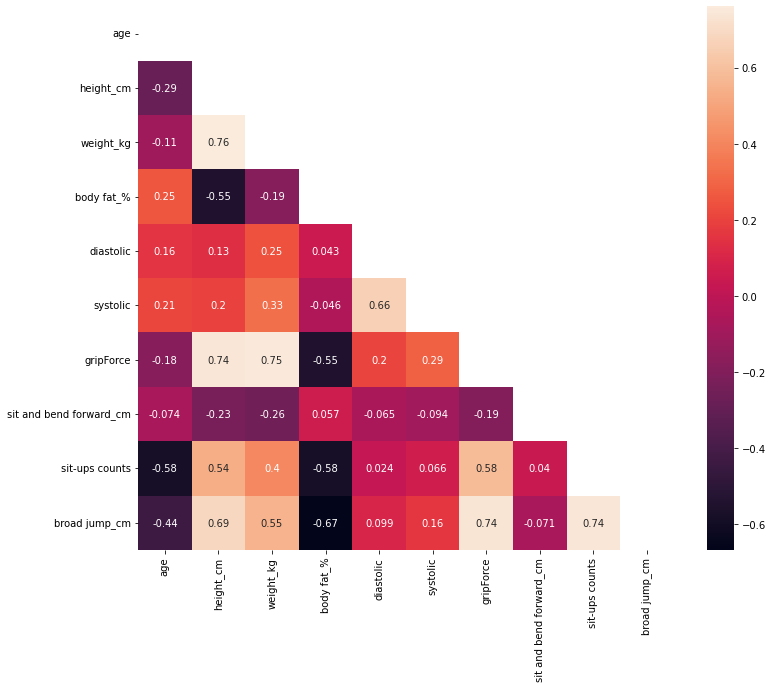

In [34]:
mask = np.zeros_like(df.corr())
tri_ind = np.triu_indices_from(df.corr())
mask[tri_ind] = True
plt.figure(figsize=[12, 10])
sns.heatmap(data=df.corr(), mask=mask, annot=True)

<b>Summary:</b><br>
1. Основываясь на матрице корелляции, мы можем сказать, что существует корреляция между ростом и весом, рост и жир тела. gripForce рост/вес. 
2. Самая большая корреляция между <b>весом</b> и <b>ростом</b> 0.76 (или 0.81 между полом и gripForce).
3. Возраст и подсчет приседаний отрицательно коррелируют, это означает, что молодые люди пресидают больше, чем пожилые люди. 
4. Существует положительная корреляция 0,76 между ростом и весом и отрицательная корреляция (-0,55) между ростом и % жиром, что означает, что у людей с большим ростом меньше жира, чем у людей с небольшим ростом. А также, чему человека рост, тем он тяжелее.
5. Существует отрицательная корреляция между телесным жиром и другими переменными (прыжки в длину, количество приседаний и сила хвата), это означает, что люди, которые делают больше прыжков в длину, приседаний и силы хвата как правило имеют меньше количество жира в организме(или наоборот).  
6. По мере того, как люди стареют или набирают вес, количество приседаний и прыжков в длину уменьшается. Эта гипотеза встречается у женщин чаще, чем у мужчин.

## XGBOOST  классификация

In [35]:
tempdf=df.copy()

In [36]:
tempdf.sample()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
256,35.0,M,165.6,88.5,40.1,87.0,136.0,33.9,7.4,6.0,151.0,D


In [37]:
tempdf=tempdf.replace({'M':0, 'F':1})
tempdf=tempdf.replace({'A':1,'B':2,'C':3,'D':4})

In [38]:
X, y = tempdf.iloc[:,:-1], tempdf.iloc[:,-1]

G:\USERS\Ksenia\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


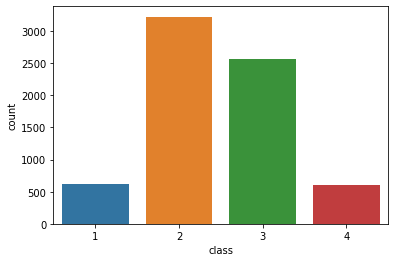

In [136]:
#Как выглядят распределение классов, они небалансированные
sns.countplot(y)

G:\USERS\Ksenia\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


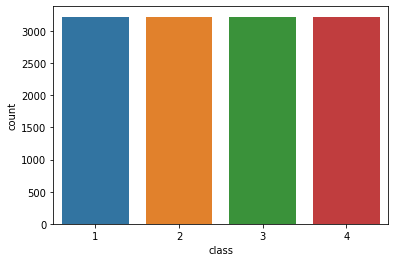

In [67]:
# Используем oversampling, undersampling и SMOTE дали хуже результать
overSample = RandomOverSampler(random_state = 402)
X_over, Y_over = overSample.fit_resample(X,y)

#Теперь сэмпл классов выглядеть хорошо
sns.countplot(Y_over);

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_over, Y_over, test_size = 0.2, random_state = 42)

In [130]:
model = XGBClassifier(verbosity=False)

# Подбор наилучших параметров для XGBoost
params = {
        'min_child_weight': [1, 3, 5, 7, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7, 9, 11]
        }

random_cv = RandomizedSearchCV (
                estimator=model,
                param_distributions=params,
                cv=5,
                n_iter=5,
                scoring='accuracy',
                n_jobs=1,
                verbose=0,
                return_train_score=True,
                random_state=121
)
random_cv.fit(X_train,y_train)

G:\USERS\Ksenia\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
G:\USERS\Ksenia\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
G:\USERS\Ksenia\AppData\Local\Pr

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [131]:
# Нужные нам параметры
random_cv.best_params_

{'subsample': 1.0,
 'min_child_weight': 3,
 'max_depth': 9,
 'gamma': 0.5,
 'colsample_bytree': 0.6}

In [132]:
model = XGBClassifier(
    colsample_bytree= 0.6,
    gamma= 0.5,
    max_depth= 9,
    min_child_weigh= 3,
    subsample= 1.0
)

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
model.fit(X_train, y_train, sample_weight=classes_weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0.5, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=9,
              min_child_weigh=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [133]:
model.score(X_train,y_train)

0.9998060135790494

In [134]:
target = model.predict(X_test)

In [135]:
accuracy = accuracy_score(y_test, target)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 90.26%


In [ ]:
cross_val_score()

## ConfusionMatrix

In [122]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [123]:
cm = confusion_matrix(y_test, target)

In [124]:
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['A', 'B', 'C', 'D'])

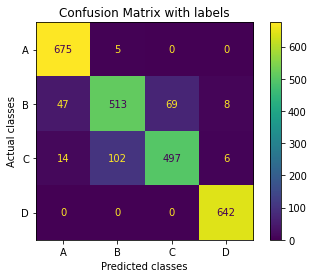

In [125]:
cmd_obj.plot()

cmd_obj.ax_.set(
                title='Confusion Matrix with labels',
                xlabel='Predicted classes', 
                ylabel='Actual classes')

plt.show()

<b>Summary:</b> Итак, у нас есть :  675 человек были классифицированы как принадлежащие к классу А. Что касается лиц класса B, то 513 человека были идентифицированы как принадлежащие к этому классу. Для лиц класса С 497 были идентифицированы правильно. Для лиц класса D 642 были идентифицированы как принадлежащие к этому классу.
Число True Positive (TP) равняется 2327.

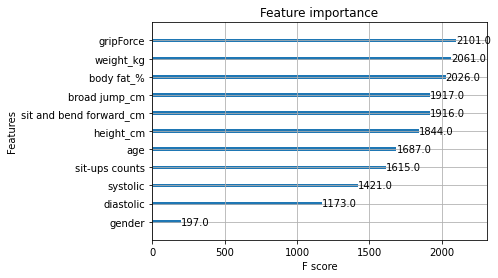

In [137]:
import xgboost as xgb
xgb.plot_importance(model);

In [138]:
class_names = ['A', 'B', 'C', 'D']
print(classification_report(y_test, target, target_names = class_names))

              precision    recall  f1-score   support

           A       0.92      0.99      0.95       680
           B       0.83      0.81      0.82       637
           C       0.88      0.80      0.84       619
           D       0.98      1.00      0.99       642

    accuracy                           0.90      2578
   macro avg       0.90      0.90      0.90      2578
weighted avg       0.90      0.90      0.90      2578



In [50]:
#Для интеграция с fastapi
import pickle

with open('model.pkl', 'wb') as pickle_out:
    pickle.dump(model, pickle_out)
